In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

import keras
from keras.models import Sequential
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, Adagrad, Adamax, SGD

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold

import tensorflow as tf

import cv2
import os

import numpy as np

# Dataset preparation

Dataset downloaded from: https://www.kaggle.com/datasets/patriciabrezeanu/big-cats-image-classification-dataset?resource=download

## Reading color images

In [2]:
#import splitfolders 
#splitfolders.ratio('animals', output="output", seed=1337, ratio=(.8, 0.2))

In [34]:
labels = ['cheetah', 'leopard', 'lion', 'tiger']
img_size = 128

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [102]:
color_train = get_data('output/train')
color_val = get_data('output/val')

/tmp/ipykernel_46578/2693023241.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


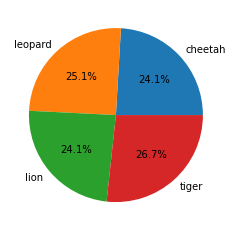

(569, 2)


In [103]:
y = np.array([np.count_nonzero(color_train[:,1] == 0), np.count_nonzero(color_train[:,1] == 1), np.count_nonzero(color_train[:,1] == 2), np.count_nonzero(color_train[:,1] == 3)])
plt.pie(y, labels = labels, autopct='%1.1f%%')
plt.show() 

print(color_train.shape)

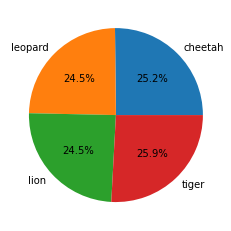

(147, 2)


In [104]:
y = np.array([np.count_nonzero(color_val[:,1] == 0), np.count_nonzero(color_val[:,1] == 1), np.count_nonzero(color_val[:,1] == 2), np.count_nonzero(color_val[:,1] == 3)])
plt.pie(y, labels = labels, autopct='%1.1f%%')
plt.show() 

print(color_val.shape)

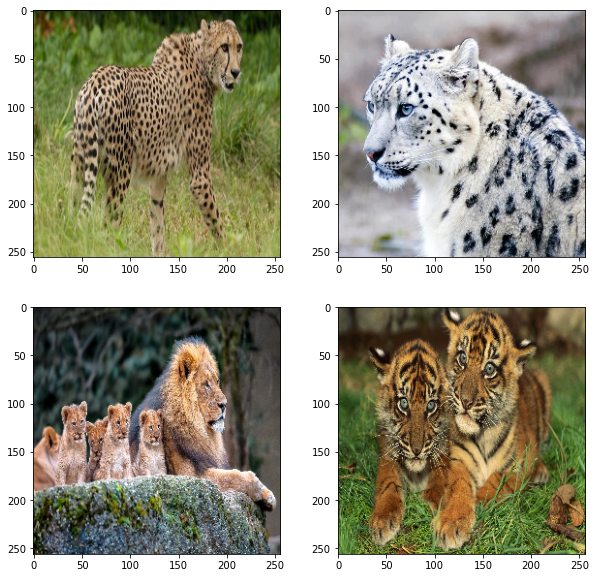

In [105]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(color_train[1][0])
axes[0, 1].imshow(color_train[160][0])
axes[1, 0].imshow(color_train[300][0])
axes[1, 1].imshow(color_train[450][0])


# Grayscale image preparation

In [106]:
def get_gray_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                data.append([gray, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [107]:
gray_train = get_gray_data('output/train')
gray_val = get_gray_data('output/val')

/tmp/ipykernel_46578/109414422.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


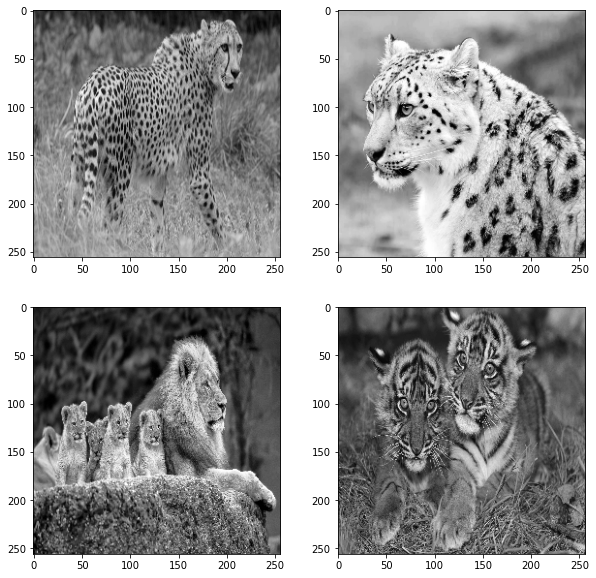

In [108]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(gray_train[1][0], cmap='gray')
axes[0, 1].imshow(gray_train[160][0], cmap='gray')
axes[1, 0].imshow(gray_train[300][0], cmap='gray')
axes[1, 1].imshow(gray_train[450][0], cmap='gray')

# Noise filtering

In [109]:
def get_gray_filtered_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [110]:
gray_filtered_train = get_gray_filtered_data('output/train')
gray_filtered_val = get_gray_filtered_data('output/val')

/tmp/ipykernel_46578/3179082502.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


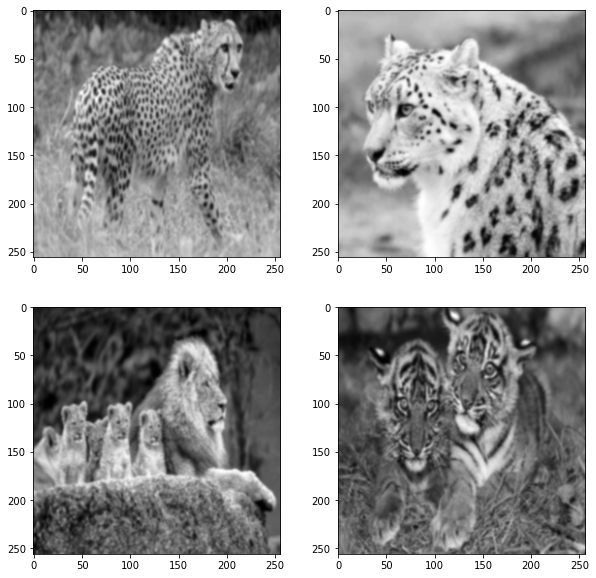

In [111]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(gray_filtered_train[1][0], cmap='gray')
axes[0, 1].imshow(gray_filtered_train[160][0], cmap='gray')
axes[1, 0].imshow(gray_filtered_train[300][0], cmap='gray')
axes[1, 1].imshow(gray_filtered_train[450][0], cmap='gray')

# Dataset expansion

In [35]:
from skimage.exposure import adjust_gamma

In [36]:
def get_expanded_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                flipped = tf.image.flip_left_right(resized_arr)
                gray = cv2.cvtColor(np.float32(flipped), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                flipped = tf.image.flip_up_down(resized_arr)
                gray = cv2.cvtColor(np.float32(flipped), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                image_dark = adjust_gamma(resized_arr, gamma=2,gain=1)
                gray = cv2.cvtColor(np.float32(image_dark), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
            except Exception as e:
                print(e)
    return np.array(data)

In [37]:
expanded_train = get_expanded_data('output/train')
expanded_val = get_expanded_data('output/val')

In [38]:
print(expanded_train.shape)
print(expanded_val.shape)

(2276, 2)
(588, 2)


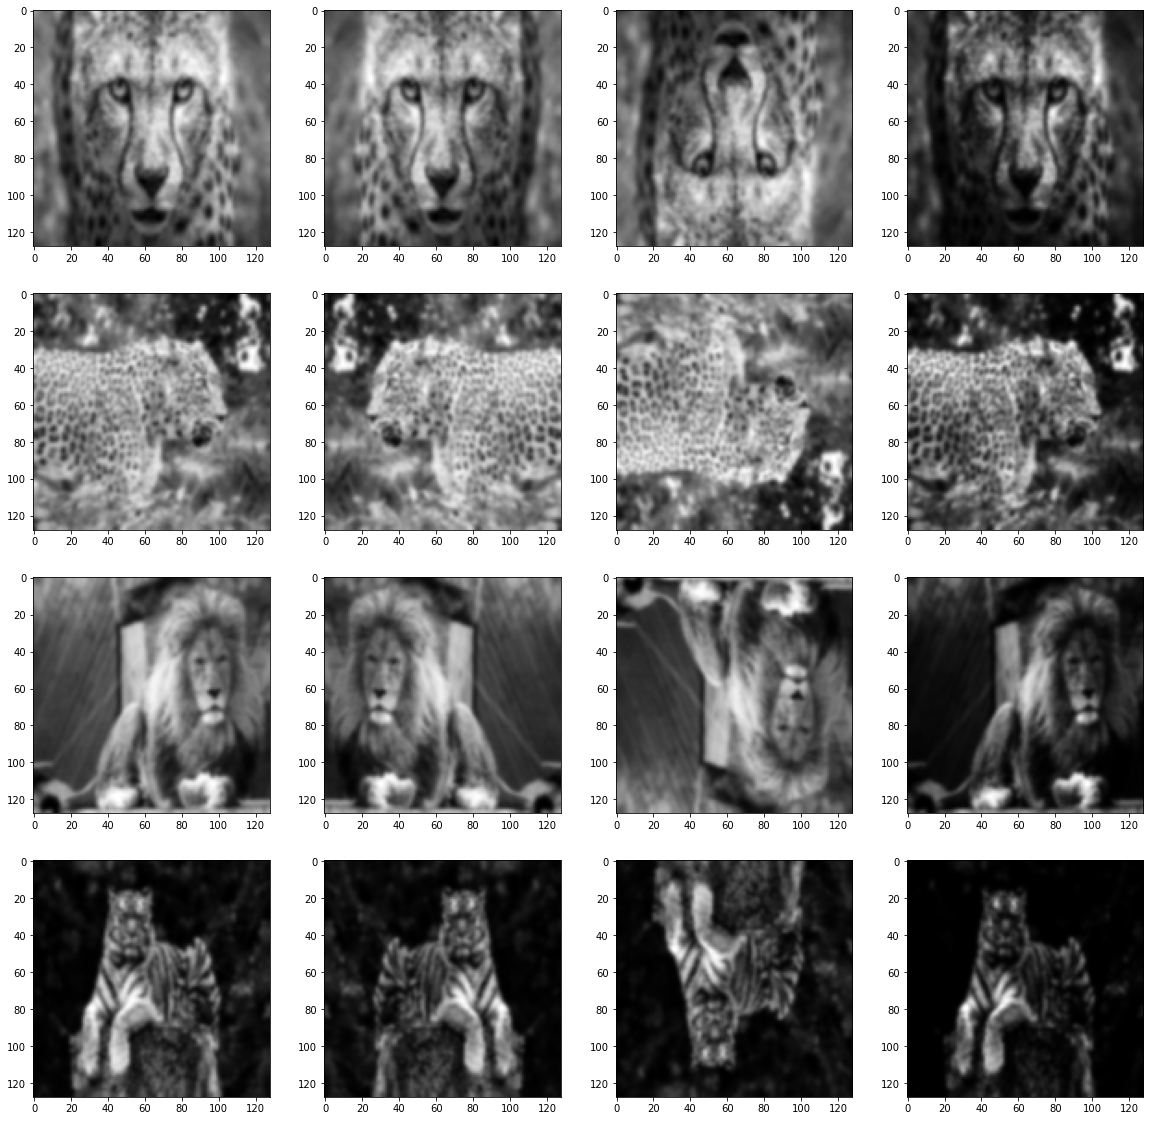

In [39]:
rows=4
cols = 4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

axes[0, 0].imshow(expanded_train[4][0], cmap='gray')
axes[0, 1].imshow(expanded_train[5][0], cmap='gray')
axes[0, 2].imshow(expanded_train[6][0], cmap='gray')
axes[0, 3].imshow(expanded_train[7][0], cmap='gray')

axes[1, 0].imshow(expanded_train[640][0], cmap='gray')
axes[1, 1].imshow(expanded_train[641][0], cmap='gray')
axes[1, 2].imshow(expanded_train[642][0], cmap='gray')
axes[1, 3].imshow(expanded_train[643][0], cmap='gray')

axes[2, 0].imshow(expanded_train[1200][0], cmap='gray')
axes[2, 1].imshow(expanded_train[1201][0], cmap='gray')
axes[2, 2].imshow(expanded_train[1202][0], cmap='gray')
axes[2, 3].imshow(expanded_train[1203][0], cmap='gray')

axes[3, 0].imshow(expanded_train[1800][0], cmap='gray')
axes[3, 1].imshow(expanded_train[1801][0], cmap='gray')
axes[3, 2].imshow(expanded_train[1802][0], cmap='gray')
axes[3, 3].imshow(expanded_train[1803][0], cmap='gray')

In [117]:
x_color_train = []
y_color_train = []
x_color_val = []
y_color_val = []

for feature, label in color_train:
  x_color_train.append(feature)
  y_color_train.append(label)

for feature, label in color_val:
  x_color_val.append(feature)
  y_color_val.append(label)

# Normalize the data
x_color_train = np.array(x_color_train) / 255
x_color_val = np.array(x_color_val) / 255

x_color_train.reshape(-1, img_size, img_size, 1)
y_color_train = np.array(y_color_train)

x_color_val.reshape(-1, img_size, img_size, 1)
y_color_val = np.array(y_color_val)



In [118]:
x_gray_train = []
y_gray_train = []
x_gray_val = []
y_gray_val = []

for feature, label in gray_train:
  x_gray_train.append(feature)
  y_gray_train.append(label)

for feature, label in gray_val:
  x_gray_val.append(feature)
  y_gray_val.append(label)

# Normalize the data
x_gray_train = np.array(x_gray_train) / 255
x_gray_val = np.array(x_gray_val) / 255

x_gray_train.reshape(-1, img_size, img_size, 1)
y_gray_train = np.array(y_gray_train)

x_gray_val.reshape(-1, img_size, img_size, 1)
y_gray_val = np.array(y_gray_val)

In [119]:
x_gray_filtered_train = []
y_gray_filtered_train = []
x_gray_filtered_val = []
y_gray_filtered_val = []

for feature, label in gray_filtered_train:
  x_gray_filtered_train.append(feature)
  y_gray_filtered_train.append(label)

for feature, label in gray_filtered_val:
  x_gray_filtered_val.append(feature)
  y_gray_filtered_val.append(label)

# Normalize the data
x_gray_filtered_train = np.array(x_gray_filtered_train) / 255
x_gray_filtered_val = np.array(x_gray_filtered_val) / 255

x_gray_filtered_train.reshape(-1, img_size, img_size, 1)
y_gray_filtered_train = np.array(y_gray_filtered_train)

x_gray_filtered_val.reshape(-1, img_size, img_size, 1)
y_gray_filtered_val = np.array(y_gray_filtered_val)

In [40]:
x_expanded_train = []
y_expanded_train = []
x_expanded_val = []
y_expanded_val = []

for feature, label in expanded_train:
  x_expanded_train.append(feature)
  y_expanded_train.append(label)

for feature, label in expanded_val:
  x_expanded_val.append(feature)
  y_expanded_val.append(label)

# Normalize the data
x_expanded_train = np.array(x_expanded_train) / 255
x_expanded_val = np.array(x_expanded_val) / 255

x_expanded_train.reshape(-1, img_size, img_size, 1)
y_expanded_train = np.array(y_expanded_train)

x_expanded_val.reshape(-1, img_size, img_size, 1)
y_expanded_val = np.array(y_expanded_val)

## Neural network

### Neural network for colour images

In [23]:
modelcolour = Sequential()
modelcolour.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
modelcolour.add(MaxPool2D())

modelcolour.add(Conv2D(32, 3, padding="same", activation="relu"))
modelcolour.add(MaxPool2D())

modelcolour.add(Conv2D(64, 3, padding="same", activation="relu"))
modelcolour.add(MaxPool2D())
modelcolour.add(Dropout(0.4))

modelcolour.add(Flatten())
modelcolour.add(Dense(128,activation="relu"))
modelcolour.add(Dense(4, activation="softmax"))

modelcolour.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

### Neural network for gray images

In [47]:
modelgray = Sequential()
modelgray.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,1)))
modelgray.add(MaxPool2D())

modelgray.add(Conv2D(32, 3, padding="same", activation="relu"))
modelgray.add(MaxPool2D())

modelgray.add(Conv2D(64, 3, padding="same", activation="relu"))
modelgray.add(MaxPool2D())
modelgray.add(Dropout(0.4))

modelgray.add(Flatten())
modelgray.add(Dense(128,activation="relu"))
modelgray.add(Dense(4, activation="softmax"))

modelgray.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 64)      

### Models training

In [49]:
opt = Adam(learning_rate=0.0001)
modelcolour.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])
modelgray.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])

In [26]:
historycolour = modelcolour.fit(x_color_train, y_color_train, batch_size = 16, epochs=20, shuffle = True)

Epoch 1/20
36/36 [==============================] - 14s 373ms/step - loss: 1.3718 - accuracy: 0.2847
Epoch 2/20
36/36 [==============================] - 14s 379ms/step - loss: 1.2027 - accuracy: 0.4622
Epoch 3/20
36/36 [==============================] - 13s 375ms/step - loss: 1.0644 - accuracy: 0.5466
Epoch 4/20
36/36 [==============================] - 14s 375ms/step - loss: 0.8935 - accuracy: 0.6696
Epoch 5/20
36/36 [==============================] - 13s 372ms/step - loss: 0.7775 - accuracy: 0.6977
Epoch 6/20
36/36 [==============================] - 13s 375ms/step - loss: 0.6874 - accuracy: 0.7610
Epoch 7/20
36/36 [==============================] - 14s 379ms/step - loss: 0.5612 - accuracy: 0.8084
Epoch 8/20
36/36 [==============================] - 13s 374ms/step - loss: 0.4494 - accuracy: 0.8805
Epoch 9/20
36/36 [==============================] - 13s 374ms/step - loss: 0.3747 - accuracy: 0.8910
Epoch 10/20
36/36 [==============================] - 13s 375ms/step - loss: 0.3387 - accura

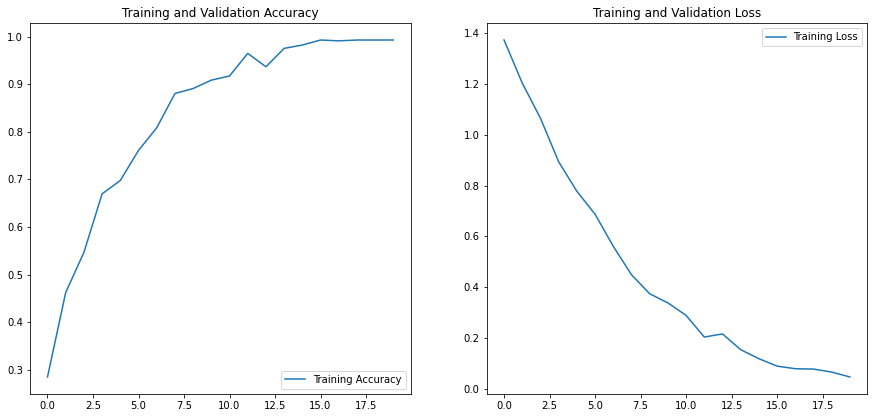

In [31]:
acc = historycolour.history['accuracy']
#val_acc = historycolour.history['val_accuracy']
loss = historycolour.history['loss']
#val_loss = historycolour.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
def test_accuracy(y_true, y_pred):
    pred = np.sum(y_true == y_pred)
    n = np.size(y_true)
    return pred/n * 100

5/5 [==============================] - 1s 93ms/step
Test accuracy:59.863945578231295%


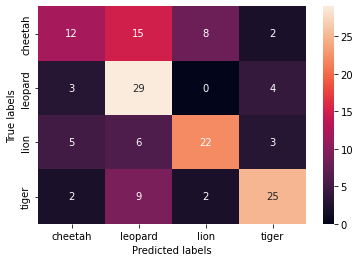

In [30]:
y_pred = modelcolour.predict(x_color_val)

confusion = confusion_matrix(y_color_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_color_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')

In [32]:
historygray = modelgray.fit(x_gray_train, y_gray_train, batch_size = 16, epochs=20, shuffle = True)

Epoch 1/20
32/32 [==============================] - 12s 373ms/step - loss: 1.3929 - accuracy: 0.3281 - val_loss: 1.5404 - val_accuracy: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 12s 367ms/step - loss: 1.2207 - accuracy: 0.4258 - val_loss: 1.5159 - val_accuracy: 0.0877
Epoch 3/20
32/32 [==============================] - 12s 372ms/step - loss: 1.0058 - accuracy: 0.5801 - val_loss: 0.9892 - val_accuracy: 0.5439
Epoch 4/20
32/32 [==============================] - 12s 371ms/step - loss: 0.8362 - accuracy: 0.6934 - val_loss: 1.0899 - val_accuracy: 0.4912
Epoch 5/20
32/32 [==============================] - 12s 375ms/step - loss: 0.6752 - accuracy: 0.7520 - val_loss: 1.2695 - val_accuracy: 0.3860
Epoch 6/20
32/32 [==============================] - 12s 376ms/step - loss: 0.6090 - accuracy: 0.7734 - val_loss: 1.0898 - val_accuracy: 0.5088
Epoch 7/20
32/32 [==============================] - 12s 373ms/step - loss: 0.4760 - accuracy: 0.8555 - val_loss: 1.0507 - val_accuracy: 0.

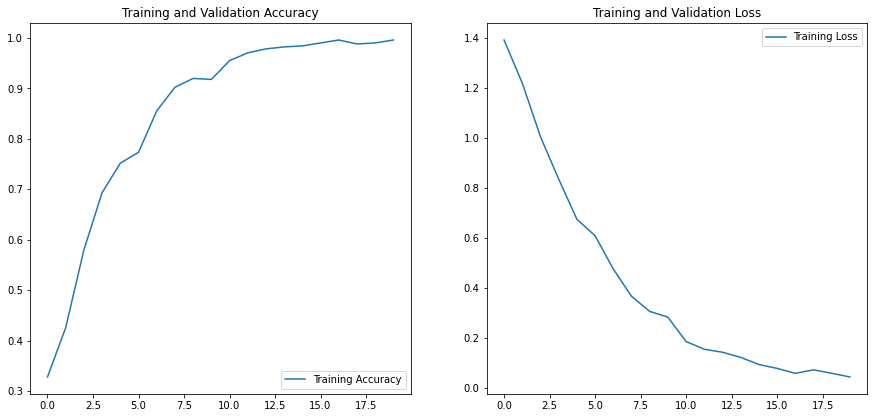

In [33]:
acc = historygray.history['accuracy']
#val_acc = historygray.history['val_accuracy']
loss = historygray.history['loss']
#val_loss = historygray.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

5/5 [==============================] - 1s 96ms/step
Test accuracy:62.585034013605444%


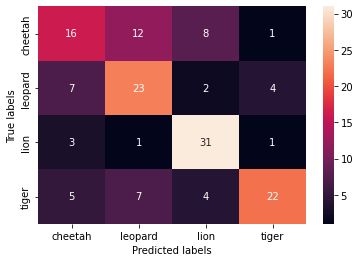

In [34]:
y_pred = modelgray.predict(x_gray_val)

confusion = confusion_matrix(y_gray_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_gray_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')

In [44]:
historygrayfilterred = modelgray.fit(x_gray_filtered_train, y_gray_filtered_train, batch_size = 16, epochs=20, shuffle = True)

Epoch 1/20
36/36 [==============================] - 13s 364ms/step - loss: 1.3814 - accuracy: 0.2689
Epoch 2/20
36/36 [==============================] - 13s 367ms/step - loss: 1.2808 - accuracy: 0.4464
Epoch 3/20
36/36 [==============================] - 13s 364ms/step - loss: 1.1741 - accuracy: 0.5378
Epoch 4/20
36/36 [==============================] - 13s 362ms/step - loss: 1.0361 - accuracy: 0.5817
Epoch 5/20
36/36 [==============================] - 13s 361ms/step - loss: 0.9109 - accuracy: 0.6661
Epoch 6/20
36/36 [==============================] - 13s 356ms/step - loss: 0.8226 - accuracy: 0.6854
Epoch 7/20
36/36 [==============================] - 13s 362ms/step - loss: 0.7322 - accuracy: 0.7364
Epoch 8/20
36/36 [==============================] - 13s 364ms/step - loss: 0.6292 - accuracy: 0.7996
Epoch 9/20
36/36 [==============================] - 13s 362ms/step - loss: 0.5381 - accuracy: 0.8366
Epoch 10/20
36/36 [==============================] - 13s 363ms/step - loss: 0.5178 - accura

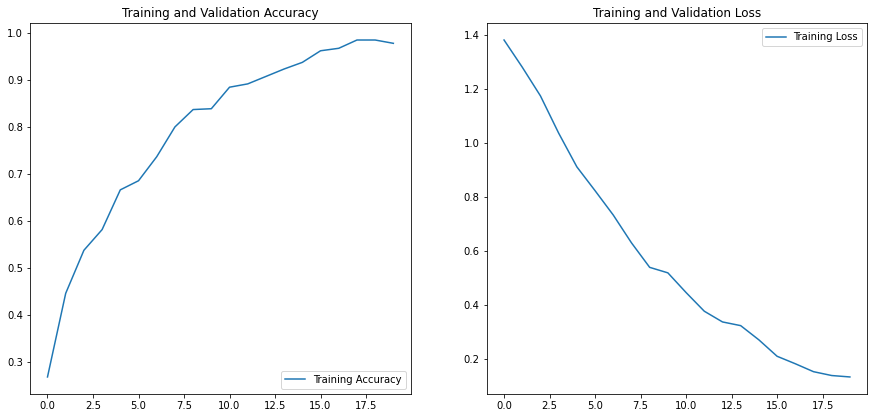

In [45]:
acc = historygrayfilterred.history['accuracy']
#val_acc = historygrayfilterred.history['val_accuracy']
loss = historygrayfilterred.history['loss']
#val_loss = historygrayfilterred.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

5/5 [==============================] - 1s 96ms/step
Test accuracy:56.4625850340136%


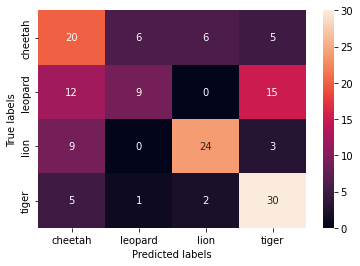

In [46]:
y_pred = modelgray.predict(x_gray_filtered_val)

confusion = confusion_matrix(y_gray_filtered_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_gray_filtered_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')

In [50]:
historyexpanded = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=20, shuffle = True)

Epoch 1/20
143/143 [==============================] - 52s 361ms/step - loss: 1.3533 - accuracy: 0.3133
Epoch 2/20
143/143 [==============================] - 52s 367ms/step - loss: 1.1651 - accuracy: 0.4974
Epoch 3/20
143/143 [==============================] - 53s 367ms/step - loss: 1.0005 - accuracy: 0.6063
Epoch 4/20
143/143 [==============================] - 52s 365ms/step - loss: 0.8992 - accuracy: 0.6380
Epoch 5/20
143/143 [==============================] - 53s 367ms/step - loss: 0.7925 - accuracy: 0.6757
Epoch 6/20
143/143 [==============================] - 52s 363ms/step - loss: 0.7080 - accuracy: 0.7307
Epoch 7/20
143/143 [==============================] - 52s 367ms/step - loss: 0.6284 - accuracy: 0.7627
Epoch 8/20
143/143 [==============================] - 52s 363ms/step - loss: 0.5753 - accuracy: 0.7996
Epoch 9/20
143/143 [==============================] - 53s 369ms/step - loss: 0.5080 - accuracy: 0.8352
Epoch 10/20
143/143 [==============================] - 52s 367ms/step - l

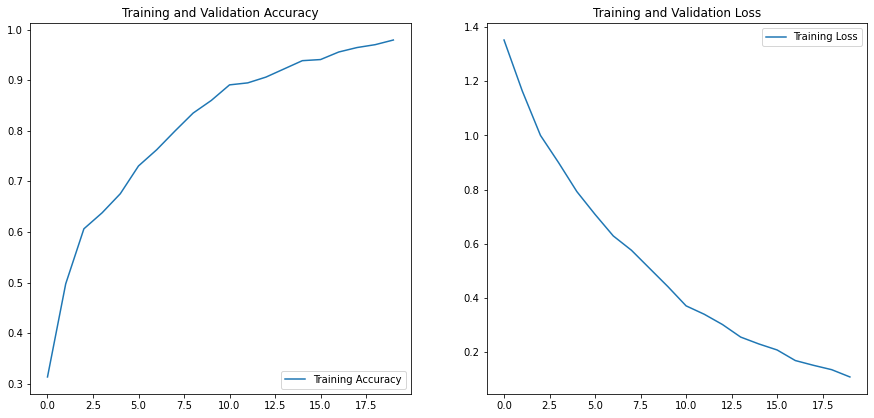

In [51]:
acc = historyexpanded.history['accuracy']
#val_acc = historyexpanded.history['val_accuracy']
loss = historyexpanded.history['loss']
#val_loss = historyexpanded.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 2s 95ms/step
Test accuracy:63.435374149659864%


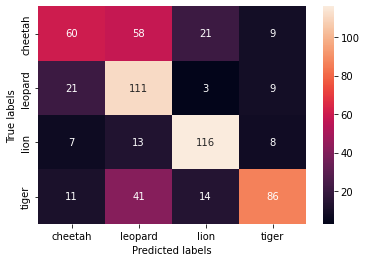

In [52]:
y_pred = modelgray.predict(x_expanded_val)

confusion = confusion_matrix(y_expanded_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_expanded_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')

## Testing neural network parameters

Additional con2D, maxpool and dropout layers. accuracy: 63.60

Additional dropout, with 0.2 rate. accuracy: 66.66

Selu activation function. accuracy: 61.39

learning rate 0.001. accuracy: 62.39

RMSprop accuracy: 67.69

Adagras accuracy: 38.44

6 conv2D. accuracy: 77.55

U-Net. accuracy: 47.45

CategoricalCrossentropy. accuracy: 62.58

In [207]:

inputs = Input((256,256,1))
c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
c1 = Dropout(0.2)(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
c2 = Dropout(0.2)(c2)
p2 = MaxPooling2D((2, 2))(c2)
 
c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
c3 = Dropout(0.2)(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
c4 = Dropout(0.2)(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
c5 = Dropout(0.3)(c5)
p5 = MaxPooling2D(pool_size=(2, 2))(c5)
 
u6 = Flatten()(p5)
u6 = Dense(128,activation="relu")(u6)
outputs = Dense(4, activation="softmax")(u6)


modelgray = tf.keras.Model(inputs = [inputs], outputs = [outputs])

In [41]:
def define_model():
    inputs = Input((128,128,1))
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
 
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.4)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
 
    u6 = Flatten()(p3)
    u6 = Dense(128,activation="relu")(u6)
    outputs = Dense(4, activation="softmax")(u6)

    modelgray = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    
    return modelgray

In [42]:
y_expanded_train = tf.one_hot(y_expanded_train, depth = 4)
y_expanded_train = np.asarray(y_expanded_train)
y_expanded_val = tf.one_hot(y_expanded_val, depth = 4)
y_expanded_val = np.asarray(y_expanded_val)

In [48]:
modelgray = define_model()
opt = RMSprop(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyone = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=20, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adam(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historytwo = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=20, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adagrad(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historythree = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=20, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfour = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=20, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = SGD(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfive = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=20, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/20
143/143 [==============================] - 17s 121ms/step - loss: 1.3950 - accuracy: 0.3168 - val_loss: 1.3413 - val_accuracy: 0.3759
Epoch 2/20
143/143 [==============================] - 17s 122ms/step - loss: 1.2242 - accuracy: 0.4631 - val_loss: 1.3534 - val_accuracy: 0.3248
Epoch 3/20
143/143 [==============================] - 18s 123ms/step - loss: 1.0087 - accuracy: 0.5923 - val_loss: 1.2328 - val_accuracy: 0.4575
Epoch 4/20
143/143 [==============================] - 18s 123ms/step - loss: 0.7476 - accuracy: 0.7219 - val_loss: 1.3953 - val_accuracy: 0.4473
Epoch 5/20
143/143 [==============================] - 18s 125ms/step - loss: 0.5488 - accuracy: 0.7939 - val_loss: 1.2747 - val_accuracy: 0.5187
Epoch 6/20
143/143 [==============================] - 18s 126ms/step - loss: 0.3941 - accuracy: 0.8598 - val_loss: 1.3029 - val_accuracy: 0.5323
Epoch 7/20
143/143 [==============================] - 18s 125ms/step - loss: 0.2736 - accuracy: 0.9121 - val_loss: 1.3322 - val_ac

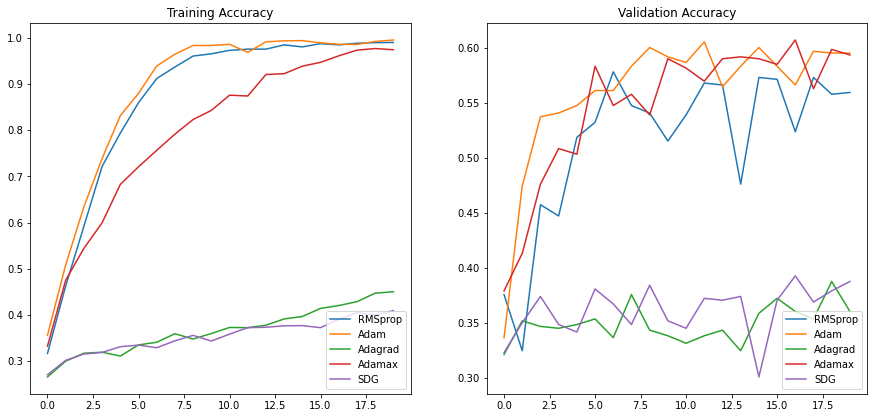

In [49]:
accone = historyone.history['accuracy']
val_acc_one = historyone.history['val_accuracy']
acctwo = historytwo.history['accuracy']
val_acc_two = historytwo.history['val_accuracy']
accthree = historythree.history['accuracy']
val_acc_three = historythree.history['val_accuracy']
accfour = historyfour.history['accuracy']
val_acc_four = historyfour.history['val_accuracy']
accfive = historyfive.history['accuracy']
val_acc_five = historyfive.history['val_accuracy']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accone, label='RMSprop')
plt.plot(epochs_range, acctwo, label='Adam')
plt.plot(epochs_range, accthree, label='Adagrad')
plt.plot(epochs_range, accfour, label='Adamax')
plt.plot(epochs_range, accfive, label='SDG')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, val_acc_one, label='RMSprop')
plt.plot(epochs_range, val_acc_two, label='Adam')
plt.plot(epochs_range, val_acc_three, label='Adagrad')
plt.plot(epochs_range, val_acc_four, label='Adamax')
plt.plot(epochs_range, val_acc_five, label='SDG')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

In [50]:
modelgray = define_model()
opt = Adamax(learning_rate=0.1)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyone = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adamax(learning_rate=0.01)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historytwo = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historythree = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adamax(learning_rate=0.0001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfour = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adamax(learning_rate=0.00001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfive = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/50
143/143 [==============================] - 17s 117ms/step - loss: 1041.0426 - accuracy: 0.2452 - val_loss: 1.6059 - val_accuracy: 0.2517
Epoch 2/50
143/143 [==============================] - 17s 118ms/step - loss: 1.4372 - accuracy: 0.2544 - val_loss: 1.4087 - val_accuracy: 0.2449
Epoch 3/50
143/143 [==============================] - 17s 116ms/step - loss: 1.4131 - accuracy: 0.2531 - val_loss: 1.3904 - val_accuracy: 0.2449
Epoch 4/50
143/143 [==============================] - 17s 116ms/step - loss: 1.3898 - accuracy: 0.2579 - val_loss: 1.3873 - val_accuracy: 0.2585
Epoch 5/50
143/143 [==============================] - 17s 118ms/step - loss: 1.3894 - accuracy: 0.2465 - val_loss: 1.3898 - val_accuracy: 0.2585
Epoch 6/50
143/143 [==============================] - 17s 121ms/step - loss: 1.3897 - accuracy: 0.2557 - val_loss: 1.3863 - val_accuracy: 0.2517
Epoch 7/50
143/143 [==============================] - 17s 117ms/step - loss: 1.3904 - accuracy: 0.2478 - val_loss: 1.3882 - val

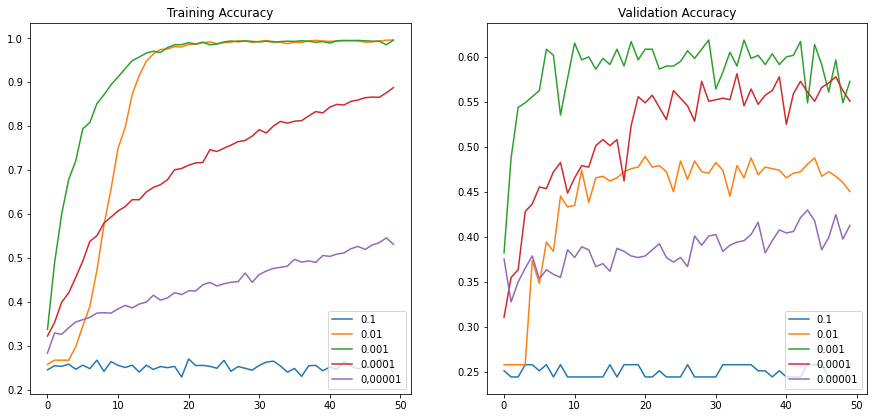

In [51]:
accone = historyone.history['accuracy']
val_acc_one = historyone.history['val_accuracy']
acctwo = historytwo.history['accuracy']
val_acc_two = historytwo.history['val_accuracy']
accthree = historythree.history['accuracy']
val_acc_three = historythree.history['val_accuracy']
accfour = historyfour.history['accuracy']
val_acc_four = historyfour.history['val_accuracy']
accfive = historyfive.history['accuracy']
val_acc_five = historyfive.history['val_accuracy']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accone, label='0.1')
plt.plot(epochs_range, acctwo, label='0.01')
plt.plot(epochs_range, accthree, label='0.001')
plt.plot(epochs_range, accfour, label='0.0001')
plt.plot(epochs_range, accfive, label='0,00001')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, val_acc_one, label='0.1')
plt.plot(epochs_range, val_acc_two, label='0.01')
plt.plot(epochs_range, val_acc_three, label='0.001')
plt.plot(epochs_range, val_acc_four, label='0.0001')
plt.plot(epochs_range, val_acc_five, label='0.00001')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

In [52]:
modelgray = define_model()
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyone = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historytwo = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historythree = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 32, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfour = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 64, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model()
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfive = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 128, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/25
285/285 [==============================] - 19s 66ms/step - loss: 1.3397 - accuracy: 0.3348 - val_loss: 1.2841 - val_accuracy: 0.4133
Epoch 2/25
285/285 [==============================] - 19s 66ms/step - loss: 1.1853 - accuracy: 0.4578 - val_loss: 1.2110 - val_accuracy: 0.4558
Epoch 3/25
285/285 [==============================] - 19s 66ms/step - loss: 1.0716 - accuracy: 0.5426 - val_loss: 1.1255 - val_accuracy: 0.4966
Epoch 4/25
285/285 [==============================] - 19s 68ms/step - loss: 0.9329 - accuracy: 0.6248 - val_loss: 1.0665 - val_accuracy: 0.5357
Epoch 5/25
285/285 [==============================] - 19s 68ms/step - loss: 0.7862 - accuracy: 0.7008 - val_loss: 1.0660 - val_accuracy: 0.5204
Epoch 6/25
285/285 [==============================] - 19s 67ms/step - loss: 0.6762 - accuracy: 0.7408 - val_loss: 0.9959 - val_accuracy: 0.5782
Epoch 7/25
285/285 [==============================] - 19s 67ms/step - loss: 0.5623 - accuracy: 0.7970 - val_loss: 0.9776 - val_accuracy:

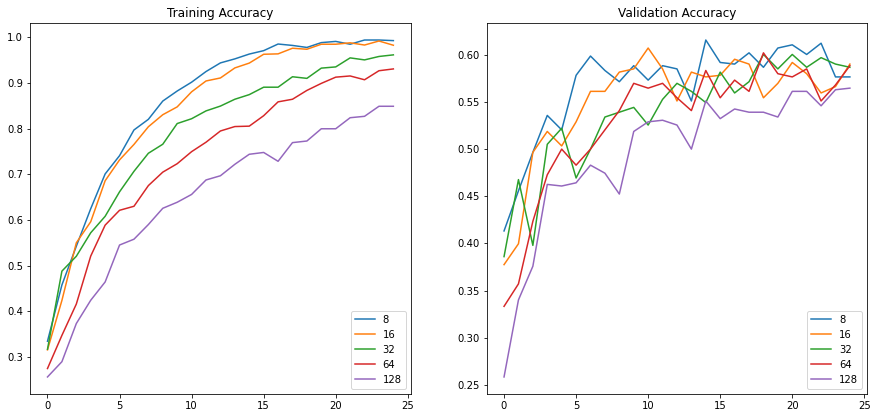

In [53]:
accone = historyone.history['accuracy']
val_acc_one = historyone.history['val_accuracy']
acctwo = historytwo.history['accuracy']
val_acc_two = historytwo.history['val_accuracy']
accthree = historythree.history['accuracy']
val_acc_three = historythree.history['val_accuracy']
accfour = historyfour.history['accuracy']
val_acc_four = historyfour.history['val_accuracy']
accfive = historyfive.history['accuracy']
val_acc_five = historyfive.history['val_accuracy']

epochs_range = range(25)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accone, label='8')
plt.plot(epochs_range, acctwo, label='16')
plt.plot(epochs_range, accthree, label='32')
plt.plot(epochs_range, accfour, label='64')
plt.plot(epochs_range, accfive, label='128')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, val_acc_one, label='8')
plt.plot(epochs_range, val_acc_two, label='16')
plt.plot(epochs_range, val_acc_three, label='32')
plt.plot(epochs_range, val_acc_four, label='64')
plt.plot(epochs_range, val_acc_five, label='128')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

In [57]:
def define_model(batch_size, activation):
    inputs = Input((128,128,1))
    c1 = Conv2D(32, (3, 3), activation=activation, padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation=activation, padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
 
    c3 = Conv2D(64, (3, 3), activation=activation, padding='same')(p2)
    c3 = Dropout(batch_size)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
 
    u6 = Flatten()(p3)
    u6 = Dense(128,activation=activation)(u6)
    outputs = Dense(4, activation="softmax")(u6)

    modelgray = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    
    return modelgray

In [55]:
modelgray = define_model(0.1, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyone = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model(0.2, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historytwo = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historythree = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model(0.4, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfour = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model(0.5, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfive = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/25
285/285 [==============================] - 19s 66ms/step - loss: 1.3420 - accuracy: 0.3304 - val_loss: 1.2644 - val_accuracy: 0.4150
Epoch 2/25
285/285 [==============================] - 19s 66ms/step - loss: 1.1518 - accuracy: 0.4921 - val_loss: 1.1765 - val_accuracy: 0.4575
Epoch 3/25
285/285 [==============================] - 19s 67ms/step - loss: 0.9878 - accuracy: 0.5813 - val_loss: 1.1711 - val_accuracy: 0.4864
Epoch 4/25
285/285 [==============================] - 19s 68ms/step - loss: 0.8388 - accuracy: 0.6687 - val_loss: 1.0537 - val_accuracy: 0.5374
Epoch 5/25
285/285 [==============================] - 19s 68ms/step - loss: 0.6911 - accuracy: 0.7434 - val_loss: 1.0494 - val_accuracy: 0.5323
Epoch 6/25
285/285 [==============================] - 19s 68ms/step - loss: 0.5995 - accuracy: 0.7737 - val_loss: 1.0627 - val_accuracy: 0.5884
Epoch 7/25
285/285 [==============================] - 20s 68ms/step - loss: 0.4997 - accuracy: 0.8207 - val_loss: 1.1347 - val_accuracy:

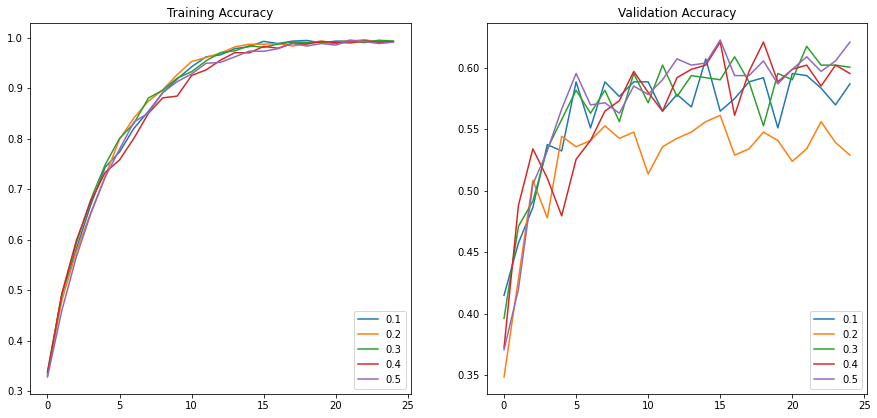

In [56]:
accone = historyone.history['accuracy']
val_acc_one = historyone.history['val_accuracy']
acctwo = historytwo.history['accuracy']
val_acc_two = historytwo.history['val_accuracy']
accthree = historythree.history['accuracy']
val_acc_three = historythree.history['val_accuracy']
accfour = historyfour.history['accuracy']
val_acc_four = historyfour.history['val_accuracy']
accfive = historyfive.history['accuracy']
val_acc_five = historyfive.history['val_accuracy']

epochs_range = range(25)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accone, label='0.1')
plt.plot(epochs_range, acctwo, label='0.2')
plt.plot(epochs_range, accthree, label='0.3')
plt.plot(epochs_range, accfour, label='0.4')
plt.plot(epochs_range, accfive, label='0.5')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, val_acc_one, label='0.1')
plt.plot(epochs_range, val_acc_two, label='0.2')
plt.plot(epochs_range, val_acc_three, label='0.3')
plt.plot(epochs_range, val_acc_four, label='0.4')
plt.plot(epochs_range, val_acc_five, label='0.5')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

In [60]:
modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyone = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model(0.3, 'selu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historytwo = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model(0.3, 'sigmoid')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historythree = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model(0.3, 'tanh')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfour = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

modelgray = define_model(0.3, 'exponential')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfive = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/25
285/285 [==============================] - 19s 68ms/step - loss: 1.3492 - accuracy: 0.3304 - val_loss: 1.3046 - val_accuracy: 0.3963
Epoch 2/25
285/285 [==============================] - 19s 68ms/step - loss: 1.1917 - accuracy: 0.4679 - val_loss: 1.1702 - val_accuracy: 0.4847
Epoch 3/25
285/285 [==============================] - 20s 69ms/step - loss: 1.0745 - accuracy: 0.5347 - val_loss: 1.2637 - val_accuracy: 0.4286
Epoch 4/25
285/285 [==============================] - 20s 70ms/step - loss: 0.9328 - accuracy: 0.6116 - val_loss: 1.1049 - val_accuracy: 0.5102
Epoch 5/25
285/285 [==============================] - 20s 70ms/step - loss: 0.7790 - accuracy: 0.6964 - val_loss: 1.0289 - val_accuracy: 0.5493
Epoch 6/25
285/285 [==============================] - 20s 70ms/step - loss: 0.6620 - accuracy: 0.7474 - val_loss: 1.0983 - val_accuracy: 0.5340
Epoch 7/25
285/285 [==============================] - 20s 70ms/step - loss: 0.5706 - accuracy: 0.7843 - val_loss: 1.0781 - val_accuracy:

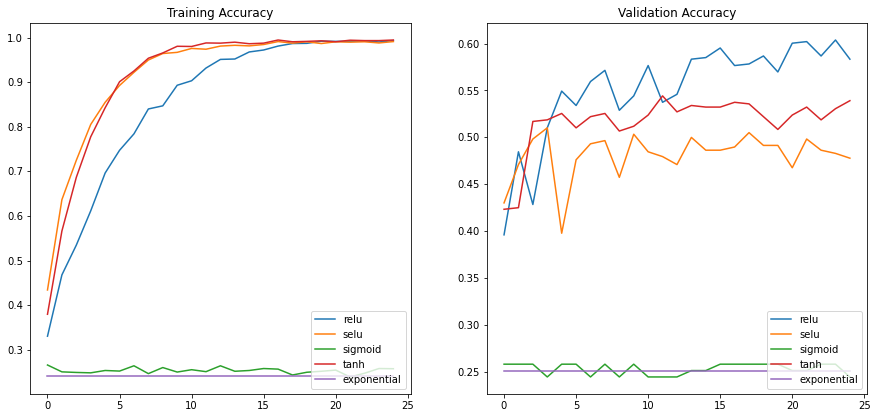

In [61]:
accone = historyone.history['accuracy']
val_acc_one = historyone.history['val_accuracy']
acctwo = historytwo.history['accuracy']
val_acc_two = historytwo.history['val_accuracy']
accthree = historythree.history['accuracy']
val_acc_three = historythree.history['val_accuracy']
accfour = historyfour.history['accuracy']
val_acc_four = historyfour.history['val_accuracy']
accfive = historyfive.history['accuracy']
val_acc_five = historyfive.history['val_accuracy']

epochs_range = range(25)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accone, label='relu')
plt.plot(epochs_range, acctwo, label='selu')
plt.plot(epochs_range, accthree, label='sigmoid')
plt.plot(epochs_range, accfour, label='tanh')
plt.plot(epochs_range, accfive, label='exponential')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, val_acc_one, label='relu')
plt.plot(epochs_range, val_acc_two, label='selu')
plt.plot(epochs_range, val_acc_three, label='sigmoid')
plt.plot(epochs_range, val_acc_four, label='tanh')
plt.plot(epochs_range, val_acc_five, label='exponential')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

In [64]:
def define_model(batch_size, activation):
    inputs = Input((128,128,1))
    c1 = Conv2D(32, (3, 3), activation=activation, padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = BatchNormalization()(p1)

    c2 = Conv2D(32, (3, 3), activation=activation, padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = BatchNormalization()(p2)
 
    c3 = Conv2D(64, (3, 3), activation=activation, padding='same')(p2)
    c3 = Dropout(batch_size)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = BatchNormalization()(p3)
 
    u6 = Flatten()(p3)
    u6 = Dense(128,activation=activation)(u6)
    outputs = Dense(4, activation="softmax")(u6)

    modelgray = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    
    return modelgray

In [63]:
modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyone = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))


Epoch 1/25
285/285 [==============================] - 20s 70ms/step - loss: 1.3289 - accuracy: 0.3366 - val_loss: 1.3272 - val_accuracy: 0.3537
Epoch 2/25
285/285 [==============================] - 20s 70ms/step - loss: 1.1765 - accuracy: 0.4758 - val_loss: 1.2035 - val_accuracy: 0.4490
Epoch 3/25
285/285 [==============================] - 20s 70ms/step - loss: 0.9699 - accuracy: 0.6063 - val_loss: 1.1634 - val_accuracy: 0.4983
Epoch 4/25
285/285 [==============================] - 21s 73ms/step - loss: 0.7725 - accuracy: 0.7039 - val_loss: 1.0287 - val_accuracy: 0.5697
Epoch 5/25
285/285 [==============================] - 20s 71ms/step - loss: 0.6436 - accuracy: 0.7570 - val_loss: 1.0275 - val_accuracy: 0.5833
Epoch 6/25
285/285 [==============================] - 20s 70ms/step - loss: 0.4956 - accuracy: 0.8203 - val_loss: 1.0564 - val_accuracy: 0.5765
Epoch 7/25
285/285 [==============================] - 20s 71ms/step - loss: 0.4355 - accuracy: 0.8493 - val_loss: 1.0350 - val_accuracy:

In [65]:
modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historytwo = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=25, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))


Epoch 1/25
285/285 [==============================] - 27s 95ms/step - loss: 1.4607 - accuracy: 0.4903 - val_loss: 7.4316 - val_accuracy: 0.2517
Epoch 2/25
285/285 [==============================] - 28s 97ms/step - loss: 0.6292 - accuracy: 0.7531 - val_loss: 2.9372 - val_accuracy: 0.2874
Epoch 3/25
285/285 [==============================] - 25s 88ms/step - loss: 0.3198 - accuracy: 0.8919 - val_loss: 1.1824 - val_accuracy: 0.5782
Epoch 4/25
285/285 [==============================] - 25s 87ms/step - loss: 0.1630 - accuracy: 0.9569 - val_loss: 1.0404 - val_accuracy: 0.5969
Epoch 5/25
285/285 [==============================] - 25s 86ms/step - loss: 0.0907 - accuracy: 0.9815 - val_loss: 1.2854 - val_accuracy: 0.6020
Epoch 6/25
285/285 [==============================] - 25s 86ms/step - loss: 0.0722 - accuracy: 0.9877 - val_loss: 1.0925 - val_accuracy: 0.6224
Epoch 7/25
285/285 [==============================] - 25s 86ms/step - loss: 0.0506 - accuracy: 0.9917 - val_loss: 1.4119 - val_accuracy:

In [97]:
def define_model(batch_size, activation):
    inputs = Input((128,128,1))
    c1 = Conv2D(32, (3, 3), activation=activation, padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation=activation, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = BatchNormalization()(p1)

    c2 = Conv2D(32, (3, 3), activation=activation, padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation=activation, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = BatchNormalization()(p2)
 
    c3 = Conv2D(64, (3, 3), activation=activation, padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation=activation, padding='same')(c3)
    c3 = Dropout(batch_size)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = BatchNormalization()(p3)
 
    c4 = Conv2D(64, (3, 3), activation=activation, padding='same')(p3)
    c4 = Conv2D(64, (3, 3), activation=activation, padding='same')(c4)
    c4 = Dropout(batch_size)(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = BatchNormalization()(p4)
    
    c5 = Conv2D(128, (3, 3), activation=activation, padding='same')(p4)
    c5 = Conv2D(128, (3, 3), activation=activation, padding='same')(c5)
    c5 = Dropout(batch_size)(c5)
    p5 = MaxPooling2D((2, 2))(c5)
    p5 = BatchNormalization()(p5)
    
    c6 = Conv2D(128, (3, 3), activation=activation, padding='same')(p5)
    c6 = Conv2D(128, (3, 3), activation=activation, padding='same')(c6)
    c6 = Dropout(batch_size)(c6)
    p6 = MaxPooling2D((2, 2))(c6)
    p6 = BatchNormalization()(p6)

    u6 = Flatten()(p6)
    u6 = Dense(128,activation=activation)(u6)
    outputs = Dense(4, activation="softmax")(u6)

    modelgray = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    
    return modelgray

In [85]:
modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyone = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/50
285/285 [==============================] - 24s 83ms/step - loss: 1.3704 - accuracy: 0.4864 - val_loss: 5.0075 - val_accuracy: 0.2517
Epoch 2/50
285/285 [==============================] - 24s 85ms/step - loss: 0.6905 - accuracy: 0.7377 - val_loss: 2.3378 - val_accuracy: 0.3333
Epoch 3/50
285/285 [==============================] - 24s 85ms/step - loss: 0.3505 - accuracy: 0.8858 - val_loss: 1.2898 - val_accuracy: 0.5136
Epoch 4/50
285/285 [==============================] - 24s 85ms/step - loss: 0.1921 - accuracy: 0.9530 - val_loss: 1.3628 - val_accuracy: 0.5153
Epoch 5/50
285/285 [==============================] - 25s 87ms/step - loss: 0.1009 - accuracy: 0.9780 - val_loss: 1.2781 - val_accuracy: 0.5629
Epoch 6/50
285/285 [==============================] - 24s 86ms/step - loss: 0.0650 - accuracy: 0.9895 - val_loss: 1.8504 - val_accuracy: 0.4847
Epoch 7/50
285/285 [==============================] - 24s 86ms/step - loss: 0.0617 - accuracy: 0.9895 - val_loss: 1.2361 - val_accuracy:

In [87]:
modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historytwo = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/50
285/285 [==============================] - 24s 86ms/step - loss: 1.3259 - accuracy: 0.5026 - val_loss: 2.8132 - val_accuracy: 0.2517
Epoch 2/50
285/285 [==============================] - 25s 87ms/step - loss: 0.8039 - accuracy: 0.6722 - val_loss: 2.0354 - val_accuracy: 0.3095
Epoch 3/50
285/285 [==============================] - 25s 88ms/step - loss: 0.5401 - accuracy: 0.7900 - val_loss: 1.1891 - val_accuracy: 0.5476
Epoch 4/50
285/285 [==============================] - 25s 89ms/step - loss: 0.3747 - accuracy: 0.8699 - val_loss: 0.9480 - val_accuracy: 0.6156
Epoch 5/50
285/285 [==============================] - 25s 89ms/step - loss: 0.2616 - accuracy: 0.9143 - val_loss: 0.9603 - val_accuracy: 0.6088
Epoch 6/50
285/285 [==============================] - 25s 89ms/step - loss: 0.1806 - accuracy: 0.9438 - val_loss: 1.1000 - val_accuracy: 0.5425
Epoch 7/50
285/285 [==============================] - 26s 91ms/step - loss: 0.1404 - accuracy: 0.9583 - val_loss: 0.9092 - val_accuracy:

In [89]:
modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historythree = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/50
285/285 [==============================] - 25s 89ms/step - loss: 1.3912 - accuracy: 0.4587 - val_loss: 2.3288 - val_accuracy: 0.2517
Epoch 2/50
285/285 [==============================] - 26s 90ms/step - loss: 0.9632 - accuracy: 0.6173 - val_loss: 1.7224 - val_accuracy: 0.2704
Epoch 3/50
285/285 [==============================] - 25s 89ms/step - loss: 0.7627 - accuracy: 0.7012 - val_loss: 1.1217 - val_accuracy: 0.4864
Epoch 4/50
285/285 [==============================] - 26s 90ms/step - loss: 0.6292 - accuracy: 0.7553 - val_loss: 1.0754 - val_accuracy: 0.5170
Epoch 5/50
285/285 [==============================] - 26s 90ms/step - loss: 0.5094 - accuracy: 0.8076 - val_loss: 1.1292 - val_accuracy: 0.5000
Epoch 6/50
285/285 [==============================] - 26s 92ms/step - loss: 0.4325 - accuracy: 0.8322 - val_loss: 1.0616 - val_accuracy: 0.5459
Epoch 7/50
285/285 [==============================] - 26s 91ms/step - loss: 0.3351 - accuracy: 0.8871 - val_loss: 0.9569 - val_accuracy:

In [91]:
modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfour = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/50
285/285 [==============================] - 26s 92ms/step - loss: 1.3715 - accuracy: 0.4236 - val_loss: 2.6269 - val_accuracy: 0.2517
Epoch 2/50
285/285 [==============================] - 26s 90ms/step - loss: 1.0587 - accuracy: 0.5545 - val_loss: 2.4724 - val_accuracy: 0.2517
Epoch 3/50
285/285 [==============================] - 27s 93ms/step - loss: 0.9510 - accuracy: 0.6120 - val_loss: 1.2947 - val_accuracy: 0.3656
Epoch 4/50
285/285 [==============================] - 26s 93ms/step - loss: 0.8401 - accuracy: 0.6643 - val_loss: 0.9691 - val_accuracy: 0.5578
Epoch 5/50
285/285 [==============================] - 26s 90ms/step - loss: 0.7311 - accuracy: 0.7061 - val_loss: 1.0773 - val_accuracy: 0.4660
Epoch 6/50
285/285 [==============================] - 26s 90ms/step - loss: 0.6421 - accuracy: 0.7417 - val_loss: 1.0772 - val_accuracy: 0.5391
Epoch 7/50
285/285 [==============================] - 26s 91ms/step - loss: 0.5932 - accuracy: 0.7728 - val_loss: 1.0163 - val_accuracy:

In [94]:
modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyfive = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/50
285/285 [==============================] - 27s 95ms/step - loss: 1.2902 - accuracy: 0.4099 - val_loss: 1.6590 - val_accuracy: 0.2517
Epoch 2/50
285/285 [==============================] - 25s 87ms/step - loss: 1.1737 - accuracy: 0.4710 - val_loss: 1.4662 - val_accuracy: 0.3248
Epoch 3/50
285/285 [==============================] - 25s 88ms/step - loss: 1.1022 - accuracy: 0.5026 - val_loss: 1.2833 - val_accuracy: 0.3333
Epoch 4/50
285/285 [==============================] - 26s 90ms/step - loss: 1.0212 - accuracy: 0.5633 - val_loss: 1.2764 - val_accuracy: 0.3486
Epoch 5/50
285/285 [==============================] - 25s 89ms/step - loss: 0.9228 - accuracy: 0.6072 - val_loss: 1.2100 - val_accuracy: 0.3759
Epoch 6/50
285/285 [==============================] - 26s 93ms/step - loss: 0.8898 - accuracy: 0.6349 - val_loss: 1.1992 - val_accuracy: 0.4252
Epoch 7/50
285/285 [==============================] - 28s 97ms/step - loss: 0.8438 - accuracy: 0.6617 - val_loss: 1.3085 - val_accuracy:

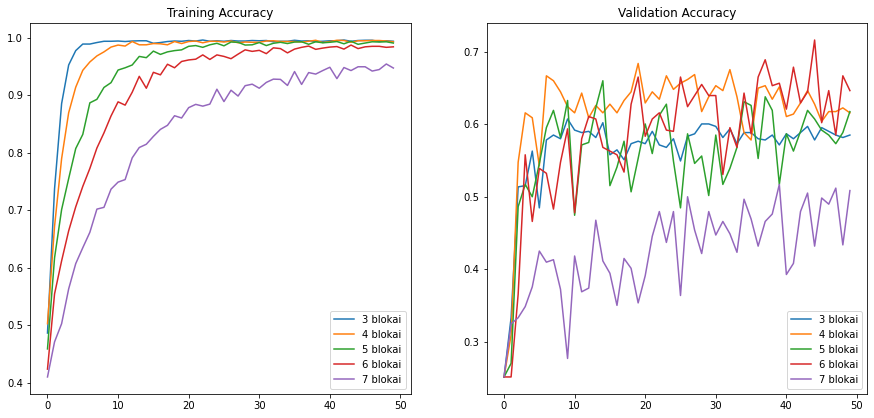

In [96]:
accone = historyone.history['accuracy']
val_acc_one = historyone.history['val_accuracy']
acctwo = historytwo.history['accuracy']
val_acc_two = historytwo.history['val_accuracy']
accthree = historythree.history['accuracy']
val_acc_three = historythree.history['val_accuracy']
accfour = historyfour.history['accuracy']
val_acc_four = historyfour.history['val_accuracy']
accfive = historyfive.history['accuracy']
val_acc_five = historyfive.history['val_accuracy']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accone, label='3 blokai')
plt.plot(epochs_range, acctwo, label='4 blokai')
plt.plot(epochs_range, accthree, label='5 blokai')
plt.plot(epochs_range, accfour, label='6 blokai')
plt.plot(epochs_range, accfive, label='7 blokai')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, val_acc_one, label='3 blokai')
plt.plot(epochs_range, val_acc_two, label='4 blokai')
plt.plot(epochs_range, val_acc_three, label='5 blokai')
plt.plot(epochs_range, val_acc_four, label='6 blokai')
plt.plot(epochs_range, val_acc_five, label='7 blokai')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

In [98]:
modelgray = define_model(0.3, 'relu')
opt = Adamax(learning_rate=0.001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])
historyone = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 8, epochs=50, shuffle = True, validation_data = (x_expanded_val, y_expanded_val))

Epoch 1/50
285/285 [==============================] - 58s 203ms/step - loss: 1.3576 - accuracy: 0.3897 - val_loss: 1.9083 - val_accuracy: 0.2517
Epoch 2/50
285/285 [==============================] - 59s 207ms/step - loss: 1.1597 - accuracy: 0.4947 - val_loss: 2.3999 - val_accuracy: 0.2517
Epoch 3/50
285/285 [==============================] - 59s 206ms/step - loss: 1.0509 - accuracy: 0.5589 - val_loss: 1.2831 - val_accuracy: 0.3452
Epoch 4/50
285/285 [==============================] - 59s 206ms/step - loss: 0.9262 - accuracy: 0.6261 - val_loss: 1.1784 - val_accuracy: 0.4847
Epoch 5/50
285/285 [==============================] - 59s 207ms/step - loss: 0.8462 - accuracy: 0.6533 - val_loss: 1.2688 - val_accuracy: 0.4541
Epoch 6/50
285/285 [==============================] - 60s 211ms/step - loss: 0.7779 - accuracy: 0.6916 - val_loss: 1.2262 - val_accuracy: 0.4354
Epoch 7/50
285/285 [==============================] - 64s 225ms/step - loss: 0.6892 - accuracy: 0.7359 - val_loss: 1.0884 - val_ac

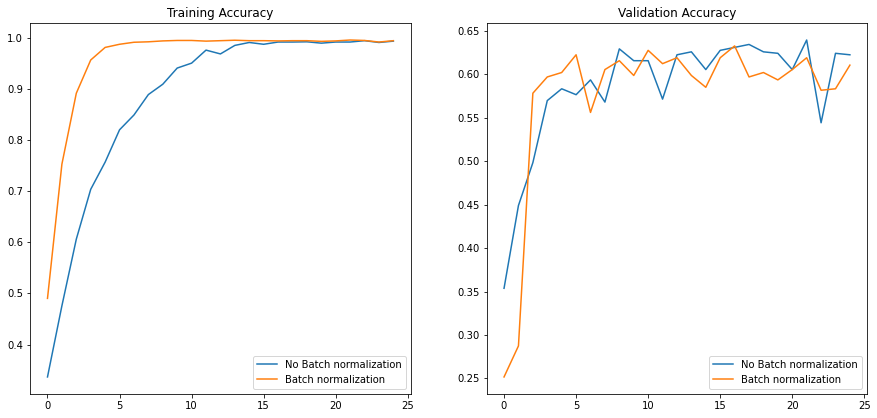

In [66]:
accone = historyone.history['accuracy']
val_acc_one = historyone.history['val_accuracy']
acctwo = historytwo.history['accuracy']
val_acc_two = historytwo.history['val_accuracy']

epochs_range = range(25)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accone, label='No Batch normalization')
plt.plot(epochs_range, acctwo, label='Batch normalization')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, val_acc_one, label='No Batch normalization')
plt.plot(epochs_range, val_acc_two, label='Batch normalization')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

Test accuracy:66.3265306122449%


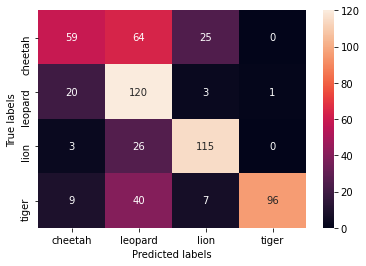

In [99]:
y_pred = modelgray.predict(x_expanded_val)

confusion = confusion_matrix(y_expanded_val.argmax(axis=1), y_pred.argmax(axis=1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_expanded_val.argmax(axis=-1), y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')

In [102]:
combined = np.concatenate((expanded_train, expanded_val),axis=0)

x = []
y = []

for feature, label in combined:
    x.append(feature)
    y.append(label)

# Normalize the data
x = np.array(x) / 255
x.reshape(-1, img_size, img_size, 1)
y = np.array(y)
y = tf.one_hot(y, depth = 4)
y = np.asarray(y)

kfold = KFold(n_splits=10, shuffle=True)
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x,y):

    modelgray = define_model(0.3, 'relu')

  # Compile the model
    opt = Adamax(learning_rate=0.001)
    modelgray.compile(optimizer = opt , loss = tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy'])


  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    historyexpanded = modelgray.fit(x[train], y[train], batch_size = 8, epochs=50, shuffle = True, validation_data = (x[test], y[test]))

  # Generate generalization metrics
    scores = modelgray.evaluate(x[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {modelgray.metrics_names[0]} of {scores[0]}; {modelgray.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
323/323 [==============================] - 67s 207ms/step - loss: 1.4000 - accuracy: 0.3655 - val_loss: 1.6657 - val_accuracy: 0.2195
Epoch 2/50
323/323 [==============================] - 69s 215ms/step - loss: 1.1947 - accuracy: 0.4622 - val_loss: 1.6862 - val_accuracy: 0.3101
Epoch 3/50
323/323 [==============================] - 67s 209ms/step - loss: 1.0615 - accuracy: 0.5510 - val_loss: 1.4432 - val_accuracy: 0.2578
Epoch 4/50
323/323 [==============================] - 70s 218ms/step - loss: 0.9608 - accuracy: 0.6026 - val_loss: 1.1968 - val_accuracy: 0.4878
Epoch 5/50
323/323 [==============================] - 71s 219ms/step - loss: 0.8762 - accuracy: 0.6411 - val_loss: 1.2073 - val_accuracy: 0.4460
Epoch 6/50
323/323 [==============================] - 67s 207ms/step - loss: 0.7947 - accuracy: 0.6814 - val_loss: 0.9448 - val_accuracy: 0.6167
Epoch 7/50
323/323 [=============